# Global Wheat Detection
## Can you help identify wheat heads using image analysis?




### *Nicolas Hubert*

More information about the challenge can be found here : https://www.kaggle.com/c/global-wheat-detection.

In this notebook, the main objective was cleaning, formatting and augmenting the data.

In [ ]:
import os
import re
import cv2
import csv
import glob
import pandas as pd
import numpy as np
import random
import itertools
from collections import Counter
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
def skip_csv_header(file):
    has_header = csv.Sniffer().has_header(file.read(1024))
    file.seek(0)
    if has_header:
        next(file)

def total_image_list(image_folder_path):
    total_img_list = [os.path.basename(img_path_name) for img_path_name in glob.glob(os.path.join(image_folder_path, "*.jpg"))]
    return total_img_list

def draw_rect(img, bboxes, color=None):
    img = img.copy()
    bboxes = bboxes[:, :4]
    bboxes = bboxes.reshape(-1, 4)
    for bbox in bboxes:
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        img = cv2.rectangle(img.copy(), pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=ceil(len(img_matrix_list) / ncols), ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

In [3]:
train = pd.read_csv("train.csv")  
image_folder_path = "train/"

In [4]:
train['bbox']

0          [834.0, 222.0, 56.0, 36.0]
1         [226.0, 548.0, 130.0, 58.0]
2         [377.0, 504.0, 74.0, 160.0]
3         [834.0, 95.0, 109.0, 107.0]
4         [26.0, 144.0, 124.0, 117.0]
                     ...             
147788      [64.0, 619.0, 84.0, 95.0]
147789    [292.0, 549.0, 107.0, 82.0]
147790    [134.0, 228.0, 141.0, 71.0]
147791     [430.0, 13.0, 184.0, 79.0]
147792     [875.0, 740.0, 94.0, 61.0]
Name: bbox, Length: 147793, dtype: object

In [5]:
train['bbox'] = train['bbox'].apply(lambda x: x[1:-1].split(","))
train['x_min'] = train['bbox'].apply(lambda x: x[0]).astype('float32')
train['y_min'] = train['bbox'].apply(lambda x: x[1]).astype('float32')
train['width'] = train['bbox'].apply(lambda x: x[2]).astype('float32')
train['height'] = train['bbox'].apply(lambda x: x[3]).astype('float32')
train = train[['image_id','x_min', 'y_min', 'width', 'height']]
train["x_max"] = train.apply(lambda col: col.x_min + col.width, axis=1)
train["y_max"] = train.apply(lambda col: col.y_min + col.height, axis = 1)
del train["width"]
del train["height"]

In [6]:
# Sanity check

train[train["x_max"] > 1024]
train[train["y_max"] > 1024]
train[train["x_min"] < 0]
train[train["y_min"] < 0]

image_id       x_min  y_min        x_max       y_max
31785  fda86ae9a  873.200012   10.4  1024.000015  196.400000
61189  b70c20580  994.400024  770.0  1024.000025  799.799999

image_id       x_min       y_min       x_max        y_max
43087  da5063a1b  464.799988  894.400024  522.999989  1024.000031

Empty DataFrame
Columns: [image_id, x_min, y_min, x_max, y_max]
Index: []

Empty DataFrame
Columns: [image_id, x_min, y_min, x_max, y_max]
Index: []

In [7]:
x_max = train["x_max"].values
y_max = train["y_max"].values
train["x_max"] = np.where(x_max > 1024, 1024, x_max).tolist()
train["y_max"] = np.where(y_max > 1024, 1024, y_max).tolist()

In [8]:
train["class"] = "1"

In [9]:
def check_file_type(image_folder_path):
    extension_type = []
    file_list = os.listdir(image_folder_path)
    for file in file_list:
        extension_type.append(file.rsplit(".", 1)[1].lower())
    print(Counter(extension_type).keys())
    print(Counter(extension_type).values())
    
check_file_type(image_folder_path)

dict_keys(['jpg'])
dict_values([3422])


In [10]:
train["image_id"] = train["image_id"].apply(lambda x: str(x) + ".jpg").astype("str")
train.head()

image_id  x_min  y_min  x_max  y_max class
0  b6ab77fd7.jpg  834.0  222.0  890.0  258.0     1
1  b6ab77fd7.jpg  226.0  548.0  356.0  606.0     1
2  b6ab77fd7.jpg  377.0  504.0  451.0  664.0     1
3  b6ab77fd7.jpg  834.0   95.0  943.0  202.0     1
4  b6ab77fd7.jpg   26.0  144.0  150.0  261.0     1

In [11]:
train.to_csv("wheat.csv", index=False)

In [12]:
def check_image_size(image_folder_path):
    total_img_list = glob.glob(os.path.join(image_folder_path,"*"))
    counter = 0
    for image in tqdm(total_img_list, desc = "Checking in progress"):
        try:
            img = cv2.imread(image)
            height, width = img.shape[1], img.shape[0]
            if not (height == 1024 and width == 1024):
                counter = counter + 1
        except:
            print("This {} is problematic.".format(image))
    return counter 

In [13]:
# check_image_size(image_folder_path)

In [14]:
wheat = pd.read_csv("wheat.csv") 
image_annotation_file = "wheat.csv"

In [15]:
def sanity_tally(image_folder_path, image_annotation_file):
    img_dict = {}
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")
        
    img_annotation_list = [*img_dict]
    total_img_list = total_image_list(image_folder_path)
    if set(img_annotation_list) == set(total_img_list):
        print("Sanity Check Status: True")
    else:
        print("Sanity Check Status: Failed. \nThe elements in wheat/train.csv but not in the train image folder is {}. \nThe elements in train image folder but not in wheat/train.csv is {}".format(
                set(img_annotation_list) - set(total_img_list), set(total_img_list) - set(img_annotation_list)))
        return list(set(img_annotation_list) - set(total_img_list)), list(set(total_img_list) - set(img_annotation_list))

In [16]:
set_diff1, set_diff2 = sanity_tally(image_folder_path, image_annotation_file)

print("There are {} images without annotations in the train/wheat.csv".format(len(set_diff2)))

Sanity Check Status: Failed. 
The elements in wheat/train.csv but not in the train image folder is set(). 
The elements in train image folder but not in wheat/train.csv is {'581eaf87b.jpg', '2e6c333a7.jpg', 'f2a6804d2.jpg', '0e7832f0b.jpg', '83a94fc79.jpg', '2d80f9c49.jpg', '7e1caf1f7.jpg', 'c74ca81bd.jpg', 'd7e657453.jpg', 'ccb3892c1.jpg', '00b5c6764.jpg', '65d0b13aa.jpg', 'dd5d2fa9e.jpg', 'f9cafa47f.jpg', 'd83808467.jpg', 'cfc9040ca.jpg', 'e4ec17f9b.jpg', '3116768f0.jpg', '39a0e5556.jpg', 'ed00a614d.jpg', '45fddc611.jpg', '69352f3fa.jpg', 'ec196d18a.jpg', '91d4e3750.jpg', 'dec23c826.jpg', '8425a537b.jpg', '46c6a747a.jpg', 'a3ce975cd.jpg', 'd771bb084.jpg', '155c440e8.jpg', 'de2a3cf37.jpg', 'ffbb9c623.jpg', '49e40c7a4.jpg', '952e7d15c.jpg', '526d737d1.jpg', '8a5cb62db.jpg', '5cbd092f9.jpg', '6584c18c0.jpg', 'e01ad95cf.jpg', 'b45c5294d.jpg', '5901a73fe.jpg', '8de789df8.jpg', 'f530a5d4b.jpg', '9e21e7969.jpg', '0cf7ef43d.jpg', 'ab20ec355.jpg', 'c18c32da0.jpg', '1a9792bfc.jpg', 'cf1d2f504.

In [17]:
def plot_random_images(image_folder_path, image_annotation_file, num = 12):
    img_dict = {}
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")

    # randomly choose 12 images to plot
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    img_matrix_list = []
    
    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file)
        img = cv2.imread(image_file_path)[:,:,::-1]  
        img_matrix_list.append(img)

    
    return plot_multiple_img(img_matrix_list, title_list = img_files_list, ncols = 4, main_title="Wheat Images")

The images' names are ['0429c9ff6.jpg' '9f8c17c70.jpg' 'f6d969b95.jpg' '834690a35.jpg'
 '667b4a999.jpg' '7e75b3e43.jpg' 'e40dcc2bf.jpg' 'a6989b72e.jpg'
 '12ef135a7.jpg' '57e21a852.jpg' 'c9175cfdd.jpg' 'b1e31c10b.jpg']


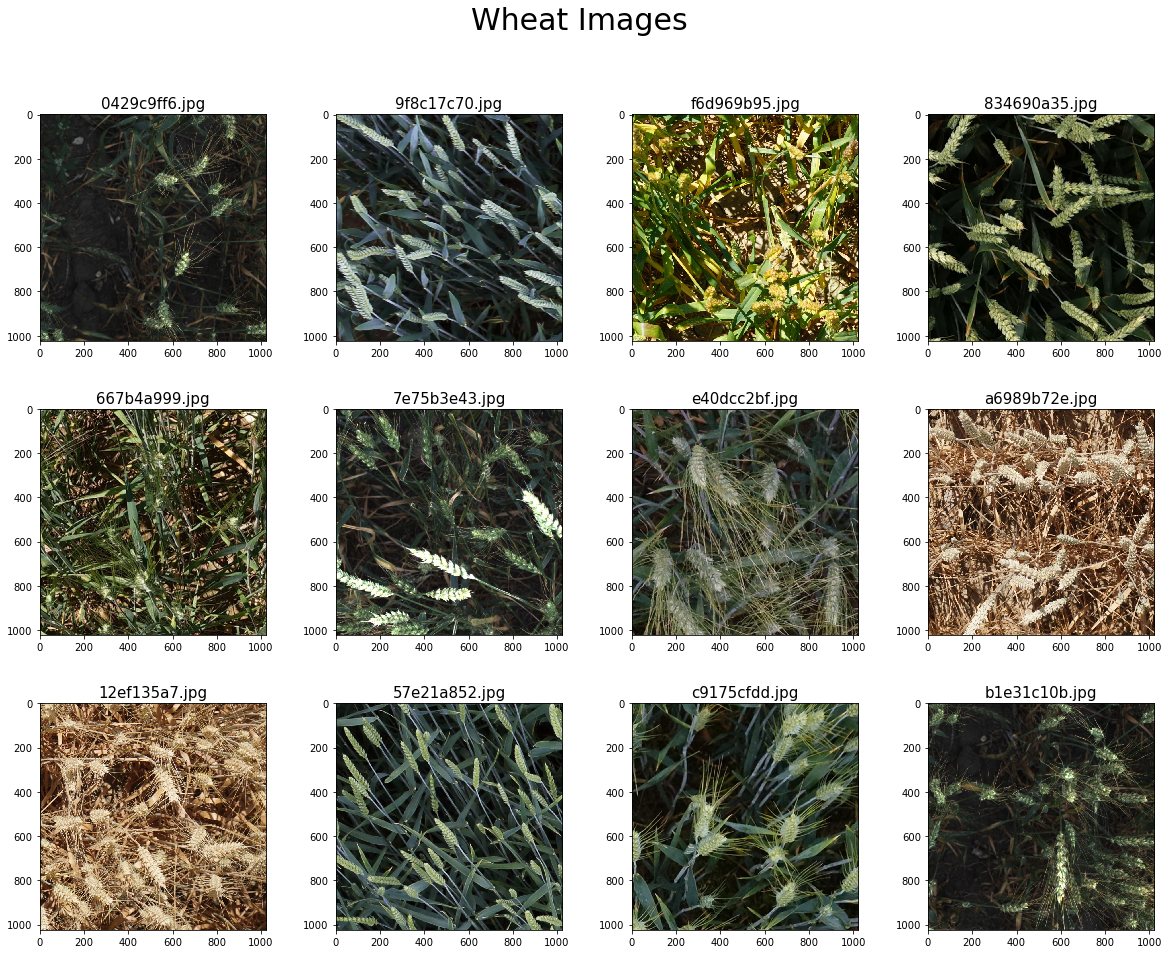

In [18]:
plot_random_images(image_folder_path, image_annotation_file, num = 12)

In [19]:
def random_bbox_check(image_folder_path, image_annotation_file, num = 12):
    img_dict = {}
    labels = ["wheat", "no wheat"]
    with open(image_annotation_file, "r") as file:
        skip_csv_header(file)
        for row in file:
            try:
                image_name, x_min, y_min, x_max, y_max, class_idx = row.split(",")
                if image_name not in img_dict:
                    img_dict[image_name] = list()
                img_dict[image_name].append(
                    [float(x_min), float(y_min), float(x_max), float(y_max), int(class_idx)]
                )
            except ValueError:
                print("Could not convert float to string, likely that your data has empty values.")

    # randomly choose 12 image.
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    image_file_path_list = []

    bbox_list = []
    img_matrix_list = []
    random_image_matrix_list = []
    
    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file)
        img = cv2.imread(image_file_path)[:,:,::-1]  
        height, width, channels = img.shape
        bbox_list.append(img_dict[img_file])
        img_matrix_list.append(img)

    
    final_bbox_list = []
    for bboxes, img in zip(bbox_list, img_matrix_list):
        final_bbox_array = np.array([])
        #bboxes is a 2d array [[...], [...]]
        for bbox in bboxes:
            bbox = np.array(bbox).reshape(1,5)
            final_bbox_array = np.append(final_bbox_array, bbox)
        final_bbox_array = final_bbox_array.reshape(-1,5)
        random_image = draw_rect(img.copy(), final_bbox_array.copy(), color = (255,0,0))
        random_image_matrix_list.append(random_image)
    plot_multiple_img(random_image_matrix_list, title_list = img_files_list, ncols = 4, main_title="Bounding Box Wheat Images") 

The images' names are ['46630486d.jpg' '2f53b1a20.jpg' '69595016d.jpg' 'c23c950a9.jpg'
 '84c56dc93.jpg' '263daaccf.jpg' '1a394df35.jpg' '952ce366b.jpg'
 '311498261.jpg' '4e02ed1d3.jpg' '5cda6a08c.jpg' '6d27a58b7.jpg']


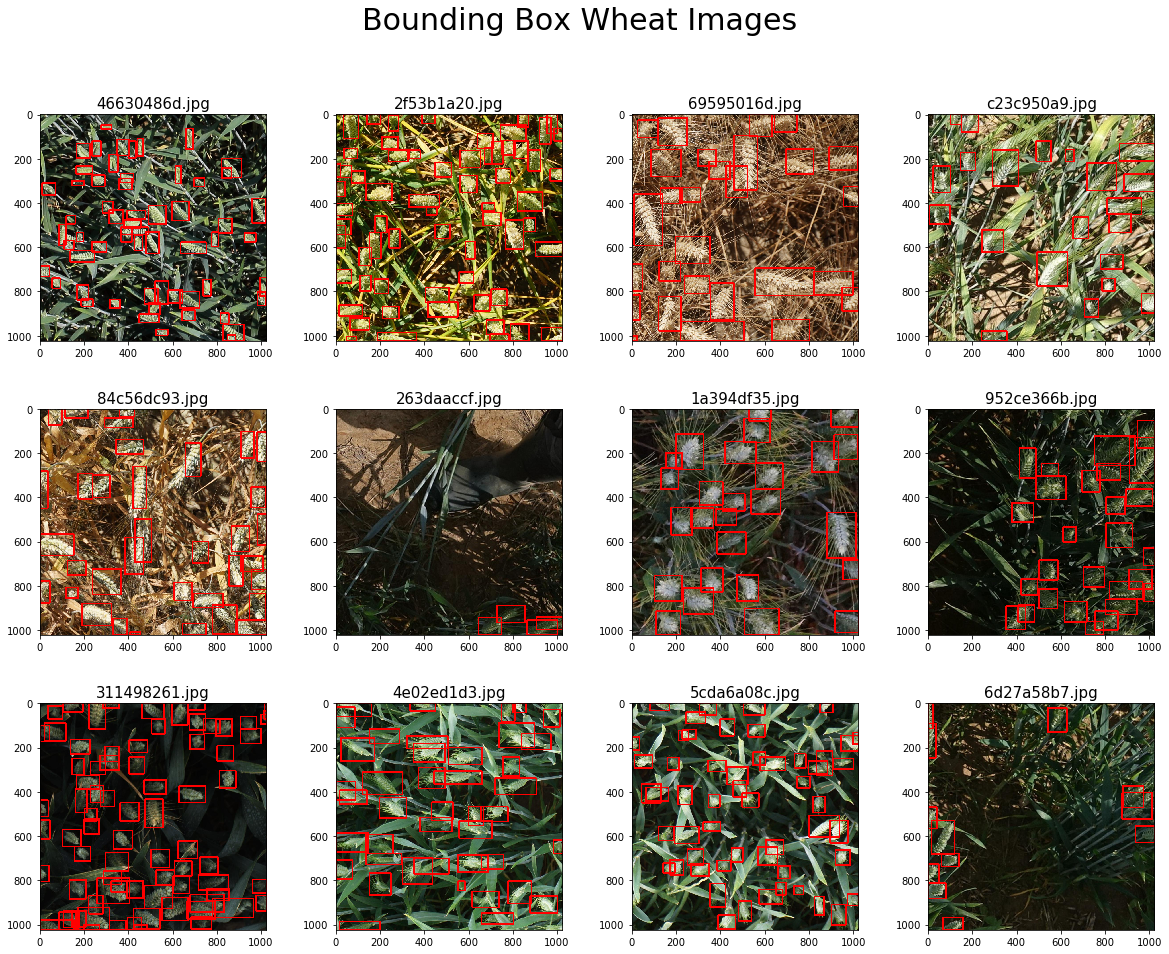

In [20]:
random_bbox_check(image_folder_path, image_annotation_file)

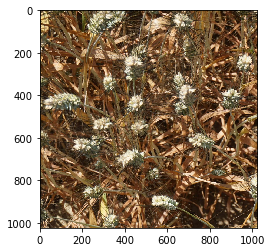

In [23]:
image_folder_path = "train/"
chosen_image = cv2.imread(os.path.join(image_folder_path, "3f5b4ef85.jpg"))[:,:,::-1]
plt.imshow(chosen_image)

In [24]:
chosen_image_dataframe = wheat.loc[wheat["image_id"]=="3f5b4ef85.jpg",["x_min","y_min","x_max","y_max","class"]]
bbox_array_of_chosen_image = np.array(chosen_image_dataframe.values.tolist())
bbox_array_of_chosen_image.shape

(29, 5)

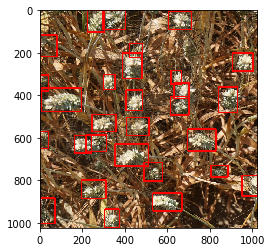

In [27]:
draw_chosen_image = draw_rect(chosen_image.copy(), bbox_array_of_chosen_image.copy(), color = (255,0,0))
plt.imshow(draw_chosen_image)

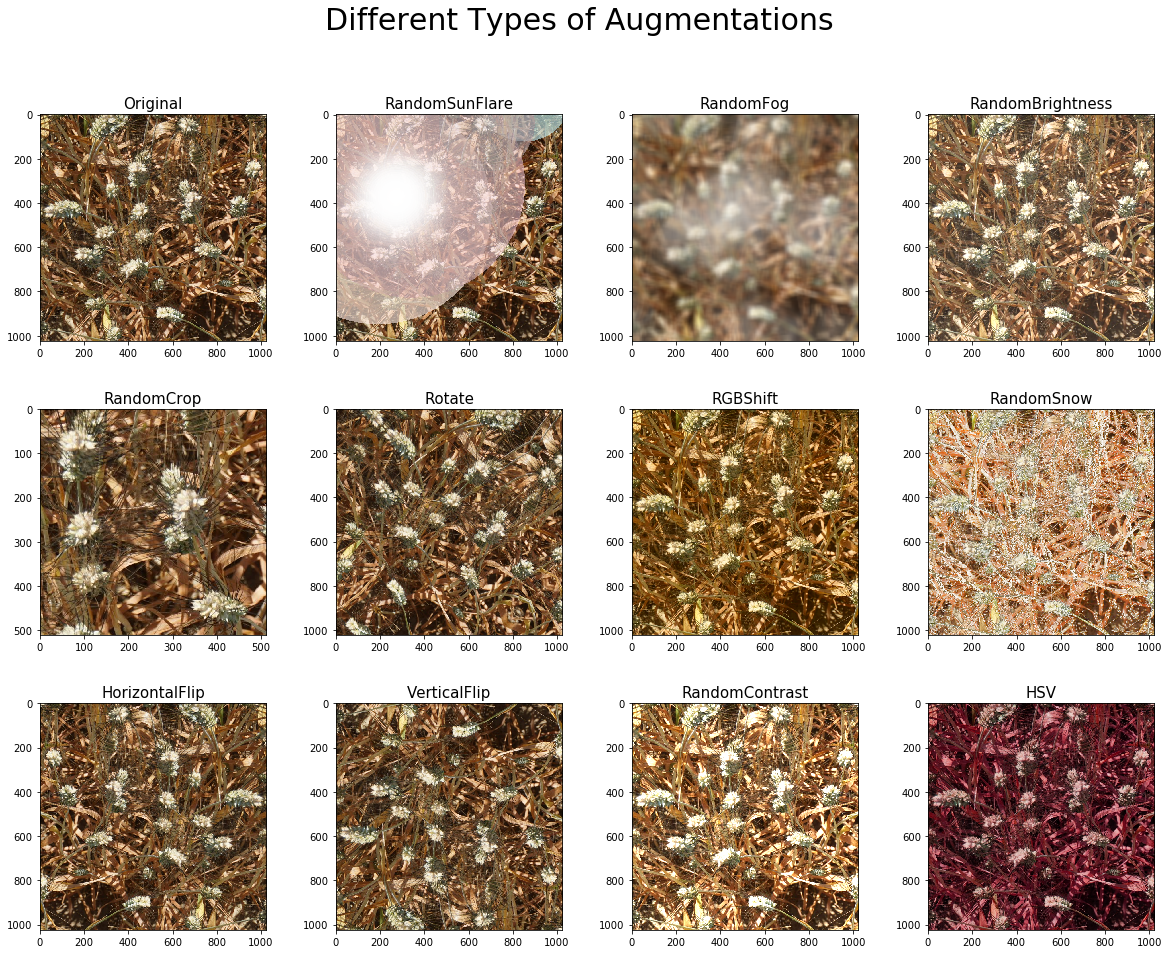

In [29]:
albumentation_list = [A.RandomSunFlare(p=1), A.RandomFog(p=1), A.RandomBrightness(p=1),
                      A.RandomCrop(p=1,height = 512, width = 512), A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), A.RandomSnow(p=1),
                      A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.RandomContrast(limit = 0.5,p = 1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","RandomSunFlare","RandomFog","RandomBrightness",
               "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4,main_title="Different Types of Augmentations")